# Compare monthly profiles
This notebook compares the multi-year monthly mean and interquartile range of the coarse data (ERA5), reference data, and the downscaled data based on the given station data of a city.

In [2]:
import os, sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from functools import partial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

import sys
import ast
sys.path.append("../../") 
from src.assess_model import *

In [3]:
RAW_INPUT_PATH = Path("../../data/01-raw/")
INPUT_PATH = Path("../../data/02-processed/")
RESULTS_PATH = Path("../../data/03-results/")
FIGS_PATH = Path("../../figs/")
YEARS = np.arange(2003,2023,1)
VARIABLE = 'tmin'
metrics_columns = ['rmse','mae','binary_accuracy']
if VARIABLE == 'precip': 
    evaluation_years = [2008,2009,2010,2016,2017,2018]
    VARIABLE_LR = 'tp'
    YLABEL = 'mm'
elif VARIABLE in ['tmin', 'tmax']: 
    evaluation_years = [2008,2009,2010,2016]
    VARIABLE_LR = 't2m_min' if VARIABLE=='tmin' else 't2m_max'
    YLABEL = '°C'

# Read data

## Read bounds

In [4]:
bounds_df = pd.read_csv(RAW_INPUT_PATH / 'domains' / 'downscaling_domains_fixed.csv')
bounds_df['full_bounds'] = bounds_df['full_bounds'].apply(ast.literal_eval)
bounds_df['focused_bounds'] = bounds_df['focused_bounds'].apply(ast.literal_eval)
bounds_df.head()

,city,full_bounds,focused_bounds
0,Dagupan,"[120.00931049408791, 120.4821769636825, 15.907...","[120.210342, 120.450668, 15.928978, 16.138177]"
1,Palayan,"[120.8625098711998, 121.33347866342953, 15.294...","[121.042557, 121.131134, 15.495371, 15.584679]"
2,MetroManila,"[120.8470354518582, 121.22452516891933, 14.273...","[120.8670354518582, 121.20452516891933, 14.293..."
3,Legazpi,"[123.63316781038878, 123.90749473184147, 12.97...","[123.68657, 123.767166, 13.113921, 13.205771]"
4,Iloilo,"[122.41374050886832, 122.69006942567574, 10.61...","[122.477646, 122.602422, 10.676429, 10.80698]"


In [5]:
OUTPUT_CITY_NAMES = bounds_df['city'].unique()

## Read station locations

In [6]:
station_locations_df = pd.read_csv(RAW_INPUT_PATH/'station_data'/'PAGASA_station_locations.csv')
station_locations_df = station_locations_df.dropna()
STATION_NAMES = station_locations_df['station_name'].values
STATION_CITY_NAMES = station_locations_df['city_name'].values
STATION_CITY_NAMES

array(['Palayan', 'Dagupan', 'Davao', 'CagayanDeOro', 'CagayanDeOro',
       'Legazpi', 'Mandaue', 'Muntinlupa', 'Navotas', 'Mandaluyong',
       'Tacloban', 'Zamboanga', 'Iloilo'], dtype=object)

## Read downscaled model output

In [7]:
output_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    out_ds = xr.load_dataset(RESULTS_PATH / VARIABLE / f"downscaled_{VARIABLE}_{city_name.lower()}_corrected.nc")
    out_ds = out_ds[VARIABLE]
    output_ds_list.update({city_name: out_ds})

## Read reference data

In [8]:
ref_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    ref_ds = xr.load_dataset(INPUT_PATH / "model_input" / f"ref_hr_{city_name.lower()}.nc")
    ref_ds = ref_ds[VARIABLE]
    ref_ds_list.update({city_name: ref_ds})

## Read coarse data

In [9]:
lr_ds_list = {}
for city_name in OUTPUT_CITY_NAMES:
    lr_ds = xr.load_dataset(INPUT_PATH / "lr_res" / f"era5_{city_name.lower()}.nc")
    lr_ds = lr_ds[VARIABLE_LR]
    lr_ds_list.update({city_name: lr_ds})

## Read station data

In [10]:
station_ds_list = {}
for city_name in STATION_CITY_NAMES:
    stn_ds = xr.load_dataset(INPUT_PATH / "station_data" / f"pagasa_station_{city_name.lower()}.nc")
    stn_ds = stn_ds[VARIABLE]
    station_ds_list.update({city_name: stn_ds})

In [11]:
station_df = pd.read_csv(INPUT_PATH/'station_data'/ f"station_data_selected_cities.csv")
station_df.head()

,city_name,station_name,date,tmin,tmax,precip
0,Palayan,Cabanatuan,2007-01-01,24.0,32.2,0.0
1,CagayanDeOro,Lumbia,2007-01-01,22.5,28.0,4.8
2,Mandaue,Mactan,2007-01-01,23.7,30.2,6.6
3,Muntinlupa,NAIA,2007-01-01,25.3,31.4,0.0
4,Davao,Davao City,2007-01-01,23.7,26.0,6.0


## Compare monthly profiles

Plotting profiles for CagayanDeOro...DONE!
Plotting profiles for Dagupan...DONE!
Plotting profiles for Davao...DONE!
Plotting profiles for Iloilo...DONE!
Plotting profiles for Legazpi...DONE!
Plotting profiles for Mandaluyong...DONE!
Plotting profiles for Mandaue...DONE!
Plotting profiles for Muntinlupa...DONE!
Plotting profiles for Navotas...DONE!
Plotting profiles for Palayan...DONE!
Plotting profiles for Tacloban...DONE!
Plotting profiles for Zamboanga...DONE!


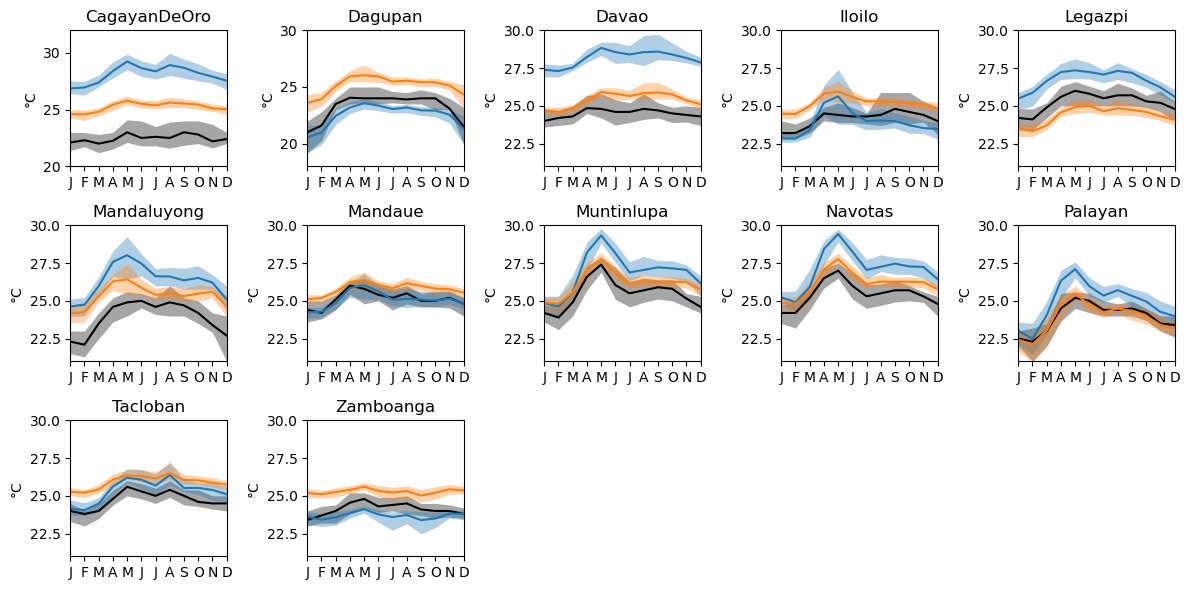

In [12]:
fig,axs = plt.subplots(3,5,figsize=(12,6))
axs = axs.flatten()

for i,city_name in enumerate(np.unique(STATION_CITY_NAMES)):
    print(f'Plotting profiles for {city_name}...', end='')
    station_location = station_locations_df[station_locations_df['city_name']==city_name][['lon','lat']].values[0]
    ## Modifications for Zamboanga
    if city_name == 'Zamboanga':
        station_location = np.array([station_location[0],station_location[1]+0.02])
    ## Modifications for Metro Manila
    output_city_name = 'MetroManila' if city_name in ['Muntinlupa', 'Navotas', 'Mandaluyong'] else city_name
    evaluation_years = [2016,2017,2018] if city_name == 'Muntinlupa' else evaluation_years
    ## Set ylims - uncomment to apply
    # # precip
    # ylims = [0,37] if city_name =='Dagupan' else [0,65] if  city_name =='Legazpi' else [0,30] 
    # # tmax
    # ylims = [24,42]
    # # tmin
    ylims = [20,32] if city_name =='CagayanDeOro'  else [18,30] if  city_name =='Dagupan'  else [21,30]
    # Select only evaluation years
    output_ds=output_ds_list[output_city_name]
    lr_ds=lr_ds_list[output_city_name]

    output_ds=output_ds.sel(time=output_ds.time.dt.year.isin(evaluation_years))
    lr_ds=lr_ds.sel(time=lr_ds.time.dt.year.isin(evaluation_years))
    # Select only evaluation years for station data
    station_ds = station_ds_list[city_name]
    station_data = station_ds.sel(time=station_ds.time.dt.year.isin(evaluation_years)).mean(dim=['lat', 'lon'], skipna=True)
    # Select station location for other data
    target_lon, target_lat = station_location
    lr_data = lr_ds.sel(lon=target_lon, lat=target_lat, method='nearest')
    output_data = output_ds.sel(lon=target_lon, lat=target_lat, method='nearest')

    compare_monthly_iqr_line_multiple([station_data,output_data,lr_data], ['Station', 'Output','Low-res'], ['k','C0','C1'], title = city_name, ylabel=YLABEL,\
                                       ylim=ylims, ax=axs[i])
    print('DONE!')
plt.delaxes(axs[12])
plt.delaxes(axs[13])
plt.delaxes(axs[14])
fig.tight_layout()
fig.savefig(FIGS_PATH / f"{VARIABLE}_profile_comparison_corrected.png", dpi=150)